<a href="https://colab.research.google.com/github/PriyanshuR23/Industrial_IOT_Predictive_Maintenance/blob/main/Final_wo_Balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer #
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import joblib
from sklearn.metrics import classification_report,accuracy_score,precision_score, recall_score, f1_score

In [ ]:

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Datasets/AI4I-PMDI.csv')

print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   UDI              Date  System Control Product ID Type  Air temperature (K)  \
0    1  15/04/2014 11:56       0       C     M14860    M                  NaN   
1    2  12/04/2014 16:09       0       A     L47181    L                298.2   
2    3  13/04/2014 01:13       0       A     L47182    L                298.1   
3    4  24/07/2014 20:35       0       B     L47183    L                  NaN   
4    5  22/07/2014 01:31       0       C     L47184    L                  NaN   

   Process temperature (K)  Rotational speed (rpm)  Torque (Nm)  \
0                      NaN                     NaN         42.8   
1                    308.7                  1408.0          NaN   
2                    308.5                  1498.0          NaN   
3                      NaN                  1433.0         39.5   
4                      NaN                     Na

In [ ]:
from IPython.display import display, HTML
display(HTML(df.head().to_html()))
print(df.isnull().sum())

,UDI,Date,System,Control,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Diagnostic
0,1,15/04/2014 11:56,0,C,M14860,M,NaN,NaN,NaN,42.8,0.0,No failure
1,2,12/04/2014 16:09,0,A,L47181,L,298.2,308.7,1408.0,NaN,NaN,No failure
2,3,13/04/2014 01:13,0,A,L47182,L,298.1,308.5,1498.0,NaN,NaN,No failure
3,4,24/07/2014 20:35,0,B,L47183,L,NaN,NaN,1433.0,39.5,NaN,No failure
4,5,22/07/2014 01:31,0,C,L47184,L,NaN,NaN,NaN,40.0,9.0,No failure


UDI                           0
Date                          0
System                        0
Control                       0
Product ID                    0
Type                          0
Air temperature (K)        6563
Process temperature (K)    6563
Rotational speed (rpm)     3321
Torque (Nm)                3437
Tool wear (min)            6679
Diagnostic                    0
dtype: int64


In [ ]:

unique_diagnostics = df['Diagnostic'].unique()
num_unique_diagnostics = len(unique_diagnostics)

print(f"Number of unique diagnostics: {num_unique_diagnostics}")
print(f"Unique diagnostic names: {unique_diagnostics}")

Number of unique diagnostics: 6
Unique diagnostic names: ['No failure' 'Power Failure' 'Overstrain Failure' 'Tool Wear Failure'
 'Random Failures' 'Heat Dissipation Failure']


***Assigning Numeric Values to the classes using Label Encoder.***

In [ ]:
label_encoder = LabelEncoder()

label_encoder.fit(df['Diagnostic'])

# 'No failure' is always 0
diagnostic_classes = list(label_encoder.classes_)
diagnostic_classes.remove('No failure')
diagnostic_classes.insert(0, 'No failure')

# Apply the adjusted mapping
label_encoder.classes_ = np.array(diagnostic_classes, dtype=object)
df['Diagnostic_encoded'] = label_encoder.transform(df['Diagnostic'])

# Create a mapping dictionary for reference
diagnostic_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Diagnostic Mapping:")
for diagnostic, encoded_value in diagnostic_mapping.items():
    print(f"{diagnostic}: {encoded_value}")

# Display the updated DataFrame with the encoded column
print("\nUpdated DataFrame with encoded 'Diagnostic' column:")
display(HTML(df.head().to_html()))

Diagnostic Mapping:
No failure: 0
Heat Dissipation Failure: 1
Overstrain Failure: 2
Power Failure: 3
Random Failures: 4
Tool Wear Failure: 5

Updated DataFrame with encoded 'Diagnostic' column:


,UDI,Date,System,Control,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Diagnostic,Diagnostic_encoded
0,1,15/04/2014 11:56,0,C,M14860,M,NaN,NaN,NaN,42.8,0.0,No failure,0
1,2,12/04/2014 16:09,0,A,L47181,L,298.2,308.7,1408.0,NaN,NaN,No failure,0
2,3,13/04/2014 01:13,0,A,L47182,L,298.1,308.5,1498.0,NaN,NaN,No failure,0
3,4,24/07/2014 20:35,0,B,L47183,L,NaN,NaN,1433.0,39.5,NaN,No failure,0
4,5,22/07/2014 01:31,0,C,L47184,L,NaN,NaN,NaN,40.0,9.0,No failure,0


In [ ]:
# Save the columns to be dropped
dropped_columns = df[['UDI', 'Date', 'System', 'Control', 'Product ID', 'Type', 'Diagnostic']]

# Create a new dataframe with dropped columns.
df_dropped = pd.DataFrame(dropped_columns)

# Export the dropped columns to a new CSV file
df_dropped.to_csv('/content/drive/MyDrive/Capstone/dropped_columns.csv', index=False)

# Drop the specified columns from the original DataFrame
df = df.drop(['UDI', 'Date', 'System', 'Control', 'Product ID', 'Type', 'Diagnostic'], axis=1)

# Display the updated DataFrame
print("\nDataFrame after dropping columns:")
display(HTML(df.head().to_html()))



DataFrame after dropping columns:


,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Diagnostic_encoded
0,NaN,NaN,NaN,42.8,0.0,0
1,298.2,308.7,1408.0,NaN,NaN,0
2,298.1,308.5,1498.0,NaN,NaN,0
3,NaN,NaN,1433.0,39.5,NaN,0
4,NaN,NaN,NaN,40.0,9.0,0


In [ ]:
numerical_cols = df.select_dtypes(include=['number']).columns
# Create an IterativeImputer object with Bayesian Ridge
imputer = IterativeImputer(estimator=BayesianRidge(), random_state=42,tol =0.01)

# Apply imputation
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Apply constraints to keep values within reasonable limits
df['Air temperature (K)'] = np.clip(df['Air temperature (K)'], 250, 400)
df['Process temperature (K)'] = np.clip(df['Process temperature (K)'], 250, 400)
df['Rotational speed (rpm)'] = np.clip(df['Rotational speed (rpm)'], 900, 3500)
df['Torque (Nm)'] = np.clip(df['Torque (Nm)'], 0, 100)
df['Tool wear (min)'] = np.clip(df['Tool wear (min)'], 0, 300)

# Display the updated DataFrame
print("\nUpdated DataFrame after imputing and clipping:")
display(HTML(df.head().to_html()))


Updated DataFrame after imputing and clipping:


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Diagnostic_encoded
0,250.0,250.0,900.0,42.800000,0.000000,0.0
1,298.2,308.7,1408.0,49.352130,101.735729,0.0
2,298.1,308.5,1498.0,44.847462,104.383550,0.0
3,250.0,250.0,1433.0,39.500000,77.538358,0.0
4,250.0,250.0,900.0,40.000000,9.000000,0.0


In [ ]:
# Count occurrences of each diagnostic
diagnostic_counts = df['Diagnostic_encoded'].value_counts()

# Calculate percentages
diagnostic_percentages = (diagnostic_counts / len(df)) * 100

# Print counts and percentages
print("Diagnostic Counts and Percentages:")
for diagnostic, count in diagnostic_counts.items():
    percentage = diagnostic_percentages[diagnostic]
    print(f"Diagnostic {diagnostic}: Count = {count}, Percentage = {percentage:.2f}%")

Diagnostic Counts and Percentages:
Diagnostic 0.0: Count = 9652, Percentage = 96.52%
Diagnostic 1.0: Count = 106, Percentage = 1.06%
Diagnostic 2.0: Count = 98, Percentage = 0.98%
Diagnostic 3.0: Count = 83, Percentage = 0.83%
Diagnostic 5.0: Count = 42, Percentage = 0.42%
Diagnostic 4.0: Count = 19, Percentage = 0.19%


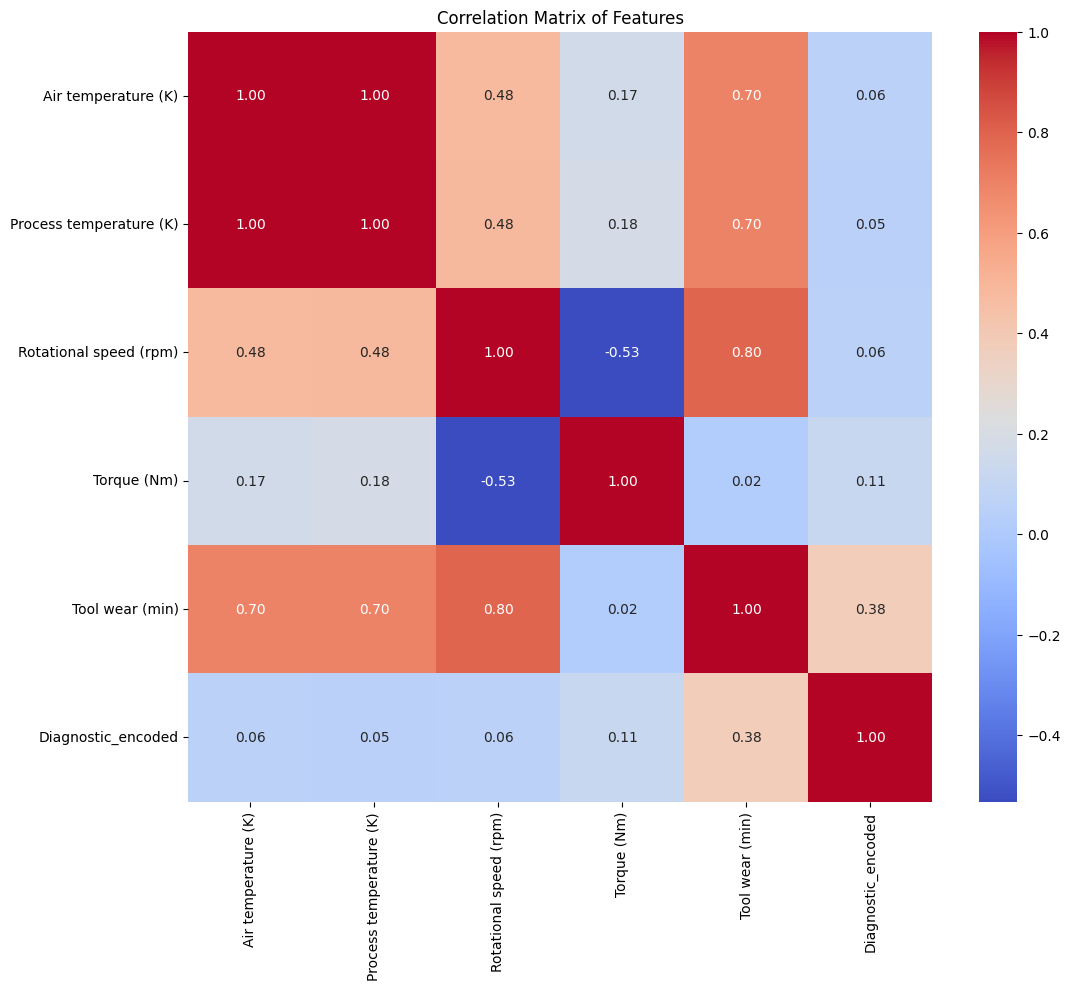

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()


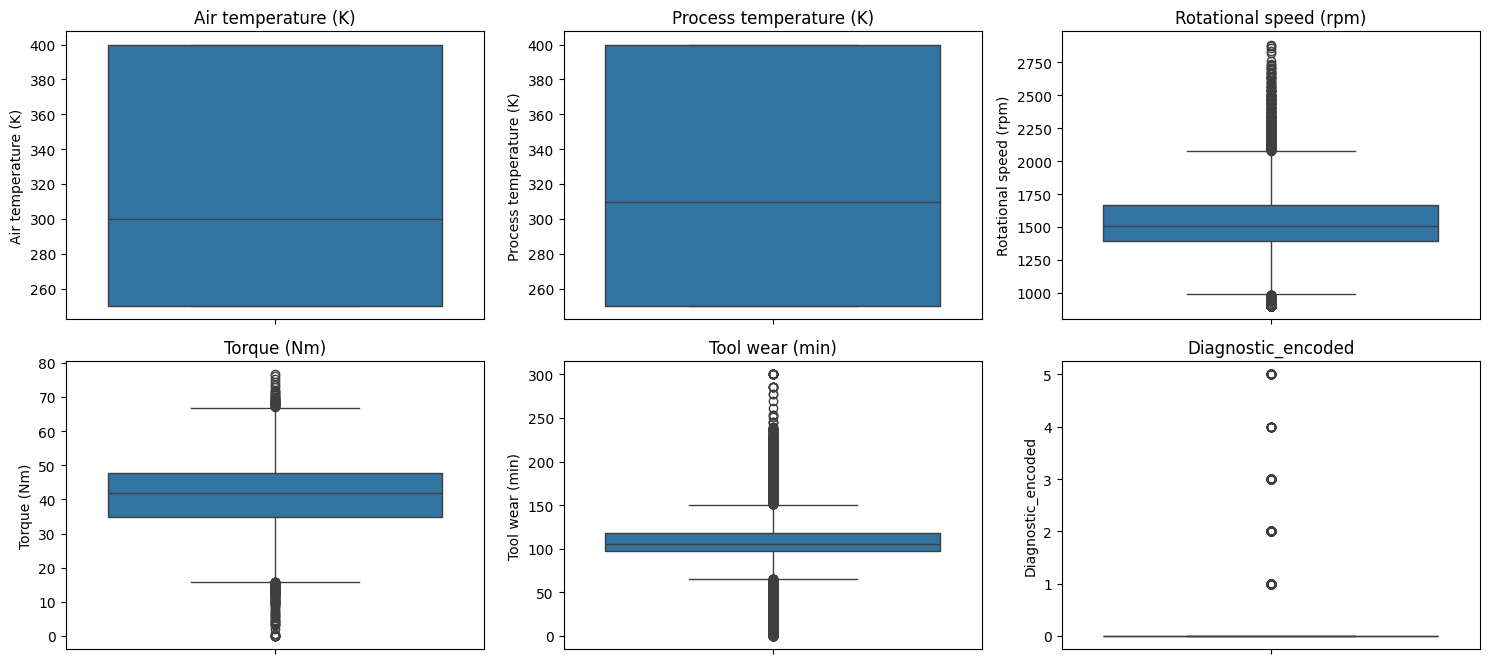

In [ ]:
# Create box plots for all numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.select_dtypes(include=np.number).columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


In [ ]:
def calculate_iqr_outliers(df):
  """
  Calculates the IQR and counts outliers for numerical features in a DataFrame.

  Args:
    df: The DataFrame to analyze.

  Returns:
    A dictionary with feature names as keys and a tuple of (IQR, outlier_count) as values.
  """
  outlier_info = {}
  for column in df.select_dtypes(include=['number']).columns:
    if column != 'Diagnostic_encoded':  # Exclude the target variable
      Q1 = df[column].quantile(0.25)
      Q3 = df[column].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      outlier_count = len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])
      outlier_info[column] = (IQR, outlier_count)
  return outlier_info

# Calculate IQR and outlier counts for df_balanced
outlier_counts_df = calculate_iqr_outliers(df)


# Print the results
for feature, (IQR, outlier_count) in outlier_counts_df.items():
  print(f"Feature: {feature}, IQR: {IQR:.2f}, Outlier Count: {outlier_count}")

Feature: Air temperature (K), IQR: 150.00, Outlier Count: 0
Feature: Process temperature (K), IQR: 150.00, Outlier Count: 0
Feature: Rotational speed (rpm), IQR: 273.00, Outlier Count: 999
Feature: Torque (Nm), IQR: 12.80, Outlier Count: 150
Feature: Tool wear (min), IQR: 21.19, Outlier Count: 2232


In [ ]:
# # Define the IQR range for 'Rotational speed (rpm)' and 'Tool wear (min)'
# Q1 = df[['Rotational speed (rpm)', 'Tool wear (min)']].quantile(0.25)
# Q3 = df[['Rotational speed (rpm)', 'Tool wear (min)']].quantile(0.75)
# IQR = Q3 - Q1

# # Define outlier boundaries
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter the DataFrame to remove outliers
# df = df[
#     (df['Rotational speed (rpm)'] >= lower_bound['Rotational speed (rpm)']) &
#     (df['Rotational speed (rpm)'] <= upper_bound['Rotational speed (rpm)']) &
#     (df['Tool wear (min)'] >= lower_bound['Tool wear (min)']) &
#     (df['Tool wear (min)'] <= upper_bound['Tool wear (min)'])
# ]

# print(f"New dataset shape after outlier removal: {df.shape}")


In [ ]:
print(df['Diagnostic_encoded'].nunique())


6


In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop(columns=['Diagnostic_encoded'])
y = df['Diagnostic_encoded']

# Get unique classes
classes = y.unique()

# Separate out each class
X_class = {cls: X[y == cls] for cls in classes}
y_class = {cls: y[y == cls] for cls in classes}

# Set aside at least one sample from each class for test
X_test_list = []
y_test_list = []

for cls in classes:
    X_cls, X_remaining, y_cls, y_remaining = train_test_split(
        X_class[cls], y_class[cls], test_size=0.8, random_state=42  # Keep 20% as test
    )

    X_test_list.append(X_cls)
    y_test_list.append(y_cls)

    X_class[cls] = X_remaining
    y_class[cls] = y_remaining

# Combine test sets
X_test = pd.concat(X_test_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)

# Combine remaining samples and split into train/val
X_remaining = pd.concat(X_class.values(), axis=0)
y_remaining = pd.concat(y_class.values(), axis=0)

X_train, X_val, y_train, y_val = train_test_split(
    X_remaining, y_remaining, test_size=0.2, random_state=42, stratify=y_remaining
)

# Print class distributions
print("Class distribution in training set:\n", y_train.value_counts())
print("Class distribution in test set:\n", y_test.value_counts())

Class distribution in training set:
 Diagnostic_encoded
0.0    6177
1.0      68
2.0      63
3.0      54
5.0      27
4.0      13
Name: count, dtype: int64
Class distribution in test set:
 Diagnostic_encoded
0.0    1930
1.0      21
2.0      19
3.0      16
5.0       8
4.0       3
Name: count, dtype: int64


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
pip install pytorch-tabnet

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight


# # Compute class weights
# class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
# class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# # Create sample weights based on the training labels
# sample_weights = np.array([class_weights_dict[label] for label in y_train])

# # Initialize the TabNet model with stronger regularization
# tabnet_model = TabNetClassifier(
#     n_d=8,               # Dimension of the prediction layer
#     n_a=8,               # Dimension of the attention layer
#     n_steps=3,           # Number of steps in the architecture
#     gamma=1.0,           # Slightly lower scaling factor (reduces sensitivity)
#     lambda_sparse=1e-2,  # Higher sparsity regularization (prevents overfitting)
#     optimizer_params=dict(lr=1e-2),  # Lower learning rate (more stable training)
#     scheduler_params={"step_size":8, "gamma":0.8},
#     scheduler_fn=torch.optim.lr_scheduler.StepLR,  # Learning rate scheduler
#     mask_type='entmax',   # Masking function
#     momentum=0.3          # Adds Dropout to prevent overfitting
# )

# # Train the model with sample weights and early stopping
# tabnet_model.fit(
#     X_train_scaled, y_train,
#     eval_set=[(X_test_scaled, y_test)],
#     eval_name=['test'],
#     eval_metric=['balanced_accuracy'],  # More robust evaluation metric
#     max_epochs=50,  # Reduce training time to prevent memorization
#     patience=5,  # Stop training if no improvement in x epochs
#     batch_size=512,  # Reduce batch size (helps generalization)
#     virtual_batch_size=512,
#     num_workers=0,
#     weights=sample_weights,  # Apply class weights
#     drop_last=False
# )
# Initialize the TabNet model
tabnet_model = TabNetClassifier(
    n_d=8,               # Dimension of the prediction layer
    n_a=8,               # Dimension of the attention layer
    n_steps=3,           # Number of steps in the architecture
    gamma=1.3,           # Scaling factor for attention updates
    lambda_sparse=1e-2,  # Sparsity regularization
    optimizer_params=dict(lr=2e-2),  # Optimizer parameters
    scheduler_params={"step_size":10, "gamma":0.9},  # Scheduler parameters
    scheduler_fn=torch.optim.lr_scheduler.StepLR,  # Learning rate scheduler
    mask_type='entmax',   # Masking function
    momentum = 0.5
)

# Train the model
tabnet_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=50,
    patience=5,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)

# Save the trained model
joblib.dump(tabnet_model, "tabnet_model.pkl")

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.2514  | test_accuracy: 0.28793 |  0:00:00s
epoch 1  | loss: 0.24397 | test_accuracy: 0.42213 |  0:00:00s
epoch 2  | loss: 0.10139 | test_accuracy: 0.41662 |  0:00:01s
epoch 3  | loss: 0.04881 | test_accuracy: 0.44517 |  0:00:01s
epoch 4  | loss: 0.03571 | test_accuracy: 0.48973 |  0:00:02s
epoch 5  | loss: 0.04184 | test_accuracy: 0.50776 |  0:00:02s
epoch 6  | loss: 0.02362 | test_accuracy: 0.7341  |  0:00:02s
epoch 7  | loss: 0.02607 | test_accuracy: 0.87031 |  0:00:03s
epoch 8  | loss: 0.02258 | test_accuracy: 0.82073 |  0:00:03s
epoch 9  | loss: 0.01721 | test_accuracy: 0.9309  |  0:00:04s
epoch 10 | loss: 0.02513 | test_accuracy: 0.97847 |  0:00:04s
epoch 11 | loss: 0.02096 | test_accuracy: 0.95043 |  0:00:05s
epoch 12 | loss: 0.02757 | test_accuracy: 0.99199 |  0:00:05s
epoch 13 | loss: 0.02028 | test_accuracy: 0.97947 |  0:00:06s
epoch 14 | loss: 0.01674 | test_accuracy: 0.98197 |  0:00:06s
epoch 15 | loss: 0.01488 | test_accuracy: 0.97546 |  0:00:06s
epoch 16

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


['tabnet_model.pkl']

In [ ]:
# Make predictions on test data
y_pred = tabnet_model.predict(X_test_scaled)

# Print evaluation metrics
print("Model Performance Metrics:")
print(classification_report(y_test, y_pred, digits=4))

Model Performance Metrics:
              precision    recall  f1-score   support

         0.0     0.9995    0.9984    0.9990      1930
         1.0     0.9130    1.0000    0.9545        21
         2.0     1.0000    1.0000    1.0000        19
         3.0     1.0000    0.9375    0.9677        16
         4.0     0.5000    0.6667    0.5714         3
         5.0     1.0000    1.0000    1.0000         8

    accuracy                         0.9975      1997
   macro avg     0.9021    0.9338    0.9154      1997
weighted avg     0.9978    0.9975    0.9976      1997



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

class NativeSparseAttention(nn.Module):
    def __init__(self, dim, num_heads):
        super(NativeSparseAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        assert self.head_dim * num_heads == dim, "dim must be divisible by num_heads"

        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.proj = nn.Linear(dim, dim)

        # Sparse attention parameters
        self.dropout = nn.Dropout(0.1)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        batch_size, seq_len, dim = x.size()

        # Project queries, keys, and values
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        # Apply sparse mask (keeping only top-k values per row)
        k = min(int(seq_len * 0.3), seq_len)  # Keep top 30% of values
        topk_values, topk_indices = torch.topk(scores, k, dim=-1)
        sparse_scores = torch.zeros_like(scores).scatter_(-1, topk_indices, topk_values)

        # Apply softmax and dropout
        attn = F.softmax(sparse_scores, dim=-1)
        attn = self.dropout(attn)

        # Apply attention to values
        out = torch.matmul(attn, v).permute(0, 2, 1, 3).reshape(batch_size, seq_len, dim)
        out = self.proj(out)

        return out

class NSALayer(nn.Module):
    def __init__(self, dim, num_heads):
        super(NSALayer, self).__init__()
        self.attention = NativeSparseAttention(dim, num_heads)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim)
        )
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Attention block
        attn_output = self.attention(x)
        x = self.norm1(x + attn_output)

        # Feed-forward block
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x

class TabNSA(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, num_heads=4, num_layers=3):
        super(TabNSA, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Input embedding
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # NSA layers
        self.nsa_layers = nn.ModuleList([NSALayer(hidden_dim, num_heads) for _ in range(num_layers)])

        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Reshape input to add sequence dimension if it's just (batch_size, features)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  # (batch_size, 1, features)

        # Embed input features
        x = self.embedding(x)

        # Apply NSA layers
        for layer in self.nsa_layers:
            x = layer(x)

        # Take the output of the last position
        x = x.squeeze(1) if x.size(1) == 1 else x.mean(dim=1)

        # Classification head
        x = self.fc(x)

        return x

In [ ]:
def prepare_data(X_train_scaled, y_train_scaled, batch_size=32, test_size=0.2, random_state=42):
    # # Split the data into training and validation sets
    # X_train_split, X_val, y_train_split, y_val = train_test_split(
    #     X_train_scaled, y_train_, test_size=test_size, random_state=random_state, stratify=y_train
    # )

    # # Scale the features
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train_split)
    # X_val_scaled = scaler.transform(X_val)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_val_tensor = torch.FloatTensor(X_test_scaled)
    y_val_tensor = torch.LongTensor(y_test.values)

    # Create DataLoader objects
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader, scaler

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # Save statistics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_tabnsa_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    return model, history

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Statistics
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total

    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

    return test_loss, test_acc, all_preds, all_targets

In [ ]:
def main(X_train, y_train):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Hyperparameters
    input_dim = X_train.shape[1]
    output_dim = 6  # Number of classes (0-5)
    hidden_dim = 64
    num_heads = 4
    num_layers = 3
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 25

    # Prepare data
    train_loader, val_loader, scaler = prepare_data(X_train, y_train, batch_size=batch_size)

    # Initialize model
    model = TabNSA(
        input_dim=input_dim,
        output_dim=output_dim,
        hidden_dim=hidden_dim,
        num_heads=num_heads,
        num_layers=num_layers
    ).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs
    )

    # Load the best model
    joblib.dump(model, "tabnsa_model.pkl") #Saving in mulitple modes for easier access during Ensemble creation
    model.load_state_dict(torch.load('best_tabnsa_model.pth'))

    # Evaluate on validation set
    val_loss, val_acc, val_preds, val_targets = evaluate_model(
        model=model,
        test_loader=val_loader,
        criterion=criterion,
        device=device
    )

    print(f"Final validation accuracy: {val_acc:.4f}")

    return model, scaler, history


In [ ]:
# Train the model
model, scaler, history = main(X_train_scaled, y_train)

Using device: cpu
Epoch 1/25 | Train Loss: 0.1559 | Train Acc: 0.9620 | Val Loss: 0.0328 | Val Acc: 0.9900
Epoch 2/25 | Train Loss: 0.0282 | Train Acc: 0.9916 | Val Loss: 0.0191 | Val Acc: 0.9950
Epoch 3/25 | Train Loss: 0.0184 | Train Acc: 0.9947 | Val Loss: 0.0151 | Val Acc: 0.9965
Epoch 4/25 | Train Loss: 0.0125 | Train Acc: 0.9973 | Val Loss: 0.0131 | Val Acc: 0.9975
Epoch 5/25 | Train Loss: 0.0163 | Train Acc: 0.9948 | Val Loss: 0.0322 | Val Acc: 0.9890
Epoch 6/25 | Train Loss: 0.0129 | Train Acc: 0.9963 | Val Loss: 0.0110 | Val Acc: 0.9985
Epoch 7/25 | Train Loss: 0.0085 | Train Acc: 0.9972 | Val Loss: 0.0103 | Val Acc: 0.9980
Epoch 8/25 | Train Loss: 0.0102 | Train Acc: 0.9970 | Val Loss: 0.0121 | Val Acc: 0.9970
Epoch 9/25 | Train Loss: 0.0107 | Train Acc: 0.9963 | Val Loss: 0.0176 | Val Acc: 0.9965
Epoch 10/25 | Train Loss: 0.0097 | Train Acc: 0.9977 | Val Loss: 0.0121 | Val Acc: 0.9970
Epoch 11/25 | Train Loss: 0.0071 | Train Acc: 0.9980 | Val Loss: 0.0263 | Val Acc: 0.9960
E

In [ ]:
def test_model(model, X_test_scaled, y_test, batch_size=64):
    # Convert to PyTorch tensors
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test.values)

    # Create test DataLoader
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set model to evaluation mode
    model.eval()

    # Initialize metrics
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_targets = []

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Calculate statistics
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

            # Store predictions and targets for further analysis
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate final metrics
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total

    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}')

    return test_loss, test_acc, all_preds, all_targets

# Load the best model
model_path = 'best_tabnsa_model.pth'
input_dim = X_test_scaled.shape[1]
output_dim = 6  # Number of classes (0-5)
hidden_dim = 64
num_heads = 4
num_layers = 3

# Initialize model with same architecture
model = TabNSA(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers
)

# Load the saved weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

# Test the model
test_loss, test_acc, test_preds, test_targets = test_model(model, X_test_scaled, y_test)

# Optional: You can add more detailed evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(test_targets, test_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(test_targets, test_preds))

Test Loss: 0.0103 | Test Accuracy: 0.9980

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        19
           3       1.00      0.94      0.97        16
           4       0.00      0.00      0.00         3
           5       0.80      1.00      0.89         8

    accuracy                           1.00      1997
   macro avg       0.80      0.82      0.81      1997
weighted avg       1.00      1.00      1.00      1997


Confusion Matrix:
[[1930    0    0    0    0    0]
 [   0   21    0    0    0    0]
 [   0    0   19    0    0    0]
 [   0    0    0   15    1    0]
 [   1    0    0    0    0    2]
 [   0    0    0    0    0    8]]


In [ ]:
loaded_model = joblib.load("tabnet_model.pkl")
print(type(loaded_model))

<class 'pytorch_tabnet.tab_model.TabNetClassifier'>


In [ ]:
# Step 1: Obtain probabilistic predictions from each model
# TabNet predictions (assuming tabnet_model is already trained)
# Load the TabNet model instead of re-initializing it
tabnet_model = joblib.load("tabnet_model.pkl")
y_proba_tabnet = tabnet_model.predict_proba(X_test_scaled)

# The rest of your code to load and use the TabNSA model remains the same...

# Load the trained TabNSA model
input_dim = X_test_scaled.shape[1]
output_dim = 6  # Number of classes (0-5)
hidden_dim = 64
num_heads = 4
num_layers = 3

# Initialize the model with the same architecture
tabnsa_model = TabNSA(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers
)

# Load the saved weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tabnsa_model.load_state_dict(torch.load('best_tabnsa_model.pth', map_location=device))
tabnsa_model = tabnsa_model.to(device)
tabnsa_model.eval()

# Get TabNSA predictions
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
with torch.no_grad():
    outputs = tabnsa_model(X_test_tensor)
    y_proba_tabnsa = torch.softmax(outputs, dim=1).cpu().numpy()

# Step 2: Assign fixed weights
weight_tabnet = 0.7
weight_tabnsa = 0.3

# Step 3: Compute weighted average of predictions
y_proba_ensemble = (weight_tabnet * y_proba_tabnet) + (weight_tabnsa * y_proba_tabnsa)

# Step 4: Make final predictions
y_pred_ensemble = np.argmax(y_proba_ensemble, axis=1)

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

Ensemble Model Accuracy: 0.9980
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1930
         1.0       0.91      1.00      0.95        21
         2.0       1.00      1.00      1.00        19
         3.0       1.00      0.94      0.97        16
         4.0       0.67      0.67      0.67         3
         5.0       1.00      1.00      1.00         8

    accuracy                           1.00      1997
   macro avg       0.93      0.93      0.93      1997
weighted avg       1.00      1.00      1.00      1997



In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "XGBR": XGBClassifier(random_state=42),
    "SVM": SVC(probability=True),
}


In [ ]:

for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Print model performance
    print(f"{name}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

    # Save trained model
    joblib.dump(model, f"{name}.pkl")

Random Forest: Accuracy = 0.9965, Precision = 0.9963, Recall = 0.9965, F1 = 0.9963
Gradient Boost: Accuracy = 0.9955, Precision = 0.9945, Recall = 0.9955, F1 = 0.9949
XGBR: Accuracy = 0.9965, Precision = 0.9955, Recall = 0.9965, F1 = 0.9960
SVM: Accuracy = 0.9670, Precision = 0.9425, Recall = 0.9670, F1 = 0.9511


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import joblib
import numpy as np
import torch
from sklearn.metrics import accuracy_score, classification_report
from torch.nn.functional import softmax

# Load trained models
tabnet_model = joblib.load("tabnet_model.pkl")
rf_model = joblib.load("Random Forest.pkl")
gb_model = joblib.load("Gradient Boost.pkl")
xgb_model = joblib.load("XGBR.pkl")
svm_model = joblib.load("SVM.pkl")

# Get probabilistic predictions
y_proba_tabnet = tabnet_model.predict_proba(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)
y_proba_gb = gb_model.predict_proba(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)
y_proba_svm = svm_model.predict_proba(X_test_scaled)

# Load and prepare TabNSA model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_test_scaled.shape[1]
output_dim = 6  # Number of classes (0-5)
hidden_dim = 64
num_heads = 4
num_layers = 3

tabnsa_model = TabNSA(input_dim, output_dim, hidden_dim, num_heads, num_layers)
tabnsa_model.load_state_dict(torch.load("best_tabnsa_model.pth", map_location=device))
tabnsa_model.to(device)
tabnsa_model.eval()

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
with torch.no_grad():
    outputs = tabnsa_model(X_test_tensor)
    y_proba_tabnsa = softmax(outputs, dim=1).cpu().numpy()

# Assign model weights (can be adjusted based on validation performance)
weights = {
    "tabnet": 0.4,
    "tabnsa": 0.2,
    "rf": 0.1,
    "gb": 0.1,
    "xgb": 0.1,
    "svm": 0.1
}

# Compute weighted average of predictions
y_proba_ensemble = (
    weights["tabnet"] * y_proba_tabnet +
    weights["tabnsa"] * y_proba_tabnsa +
    weights["rf"] * y_proba_rf +
    weights["gb"] * y_proba_gb +
    weights["xgb"] * y_proba_xgb +
    weights["svm"] * y_proba_svm
)

# Final ensemble predictions
y_pred_ensemble = np.argmax(y_proba_ensemble, axis=1)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Ensemble Model Accuracy: 0.9990
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1930
         1.0       1.00      1.00      1.00        21
         2.0       1.00      1.00      1.00        19
         3.0       1.00      0.94      0.97        16
         4.0       0.67      0.67      0.67         3
         5.0       1.00      1.00      1.00         8

    accuracy                           1.00      1997
   macro avg       0.94      0.93      0.94      1997
weighted avg       1.00      1.00      1.00      1997

